# Exploratory Spatio-Temporal Data Analysis
# Part 1 - Data Inspection and Descriptive Statistics - Summary Statistics

In [15]:
import gc

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt

import folium
from mpl_toolkits.basemap import Basemap

%matplotlib inline

In [16]:
polars_df = pl.read_parquet("/workspace/ml-drought-forecasting/ml-modeling-pipeline/data/03_primary/preprocessed_data.parquet")

In [17]:
polars_df

shape: (3_650_640, 58)
┌───────┬────────┬────────────┬───────────┬───┬───────────────┬──────────────┬──────────────┬──────┐
│ lat   ┆ lon    ┆ time       ┆ T2M       ┆ … ┆ eddi_06mn_cat ┆ eddi_09mn_ca ┆ eddi_12mn_ca ┆ id   │
│ ---   ┆ ---    ┆ ---        ┆ ---       ┆   ┆ egory_encoded ┆ tegory_encod ┆ tegory_encod ┆ ---  │
│ f64   ┆ f64    ┆ date       ┆ f64       ┆   ┆ ---           ┆ ed           ┆ ed           ┆ u32  │
│       ┆        ┆            ┆           ┆   ┆ i32           ┆ ---          ┆ ---          ┆      │
│       ┆        ┆            ┆           ┆   ┆               ┆ i32          ┆ i32          ┆      │
╞═══════╪════════╪════════════╪═══════════╪═══╪═══════════════╪══════════════╪══════════════╪══════╡
│ -11.5 ┆ 35.0   ┆ 1981-09-06 ┆ 22.741741 ┆ … ┆ 2             ┆ 3            ┆ 4            ┆ 565  │
│ -11.5 ┆ 35.625 ┆ 1981-09-06 ┆ 24.041964 ┆ … ┆ 1             ┆ 3            ┆ 4            ┆ 1458 │
│ -11.5 ┆ 36.25  ┆ 1981-09-06 ┆ 24.779688 ┆ … ┆ 0             ┆ 3            ┆ 3            ┆ 1446 │
│ -11.5 ┆ 36.875 ┆ 1981-09-06 ┆ 25.352232 ┆ … ┆ 0             ┆ 2            ┆ 3            ┆ 1253 │
│ -11.5 ┆ 37.5   ┆ 1981-09-06 ┆ 25.962723 ┆ … ┆ 0             ┆ 2            ┆ 3            ┆ 392  │
│ …     ┆ …      ┆ …          ┆ …         ┆ … ┆ …             ┆ …            ┆ …            ┆ …    │
│ 22.0  ┆ 33.125 ┆ 2024-04-28 ┆ 29.615625 ┆ … ┆ -1            ┆ -5           ┆ -5           ┆ 1127 │
│ 22.0  ┆ 34.375 ┆ 2024-04-28 ┆ 31.111719 ┆ … ┆ -1            ┆ -5           ┆ -5           ┆ 490  │
│ 22.0  ┆ 35.0   ┆ 2024-04-28 ┆ 29.596094 ┆ … ┆ -1            ┆ -4           ┆ -5           ┆ 422  │
│ 22.0  ┆ 35.625 ┆ 2024-04-28 ┆ 28.021875 ┆ … ┆ -1            ┆ -4           ┆ -5           ┆ 285  │
│ 22.0  ┆ 36.25  ┆ 2024-04-28 ┆ 29.053125 ┆ … ┆ 2             ┆ -3           ┆ -4           ┆ 295  │
└───────┴────────┴────────────┴───────────┴───┴───────────────┴──────────────┴──────────────┴──────┘

## Data Inspection

### Area of intrest - East Africa

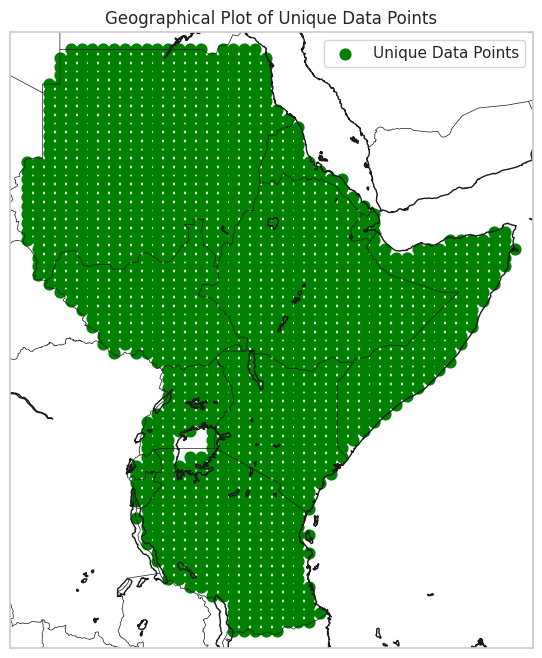

In [18]:
def plot_geographical_data(polars_df: pl.DataFrame):
    """
    Plots unique geographical data points on a map from a Polars DataFrame containing latitude and longitude.

    Parameters:
    - polars_df (pl.DataFrame): A Polars DataFrame with 'lat' and 'lon' columns.

    Author:
    - Adam Przychodni
    """
    # Ensure the DataFrame has the necessary columns
    if not {'lat', 'lon'}.issubset(polars_df.columns):
        raise ValueError("DataFrame must contain 'lat' and 'lon' columns")

    # Select the latitude and longitude columns and get unique pairs
    unique_coords = polars_df.select(['lat', 'lon']).unique()

    # Extract longitude and latitude columns from the unique coordinates
    lons = unique_coords.get_column('lon').to_numpy()
    lats = unique_coords.get_column('lat').to_numpy()

    # Set up the plot with a specified size
    fig, ax = plt.subplots(figsize=(12, 8))

    # Create a Basemap instance with a cylindrical projection
    m = Basemap(projection='cyl', llcrnrlon=lons.min() - 1, llcrnrlat=lats.min() - 1,
                urcrnrlon=lons.max() + 1, urcrnrlat=lats.max() + 1, resolution='i', ax=ax)

    # Draw coastlines and countries for better map visualization
    m.drawcoastlines()
    m.drawcountries()

    # Convert latitude and longitude to map projection coordinates
    x, y = m(lons, lats)

    # Plot the data points with a green color, 'o' marker, and size of 60
    m.scatter(x, y, color='green', label='Unique Data Points', marker='o', s=60)

    # Add a legend and a title to the plot
    plt.legend()
    plt.title('Geographical Plot of Unique Data Points')

    # Display the plot
    plt.show()

    # Close the plot to free up memory
    plt.close(fig)
    
    # Explicitly delete variables and collect garbage
    del m, x, y, lons, lats, unique_coords, fig, ax
    gc.collect()

# Example usage:
plot_geographical_data(polars_df)


### Missing values

In [19]:
def calculate_missing_percentages(df: pl.DataFrame, missing_value: float = None) -> pl.DataFrame:
    """
    Calculates the percentage of missing values in each column of a Polars DataFrame, 
    considering a specified missing value.

    Parameters:
    - df (pl.DataFrame): The input DataFrame with potentially missing values.
    - missing_value (float, optional): A custom value to treat as missing. Default is None, which means only None values are considered missing.

    Returns:
    - pl.DataFrame: A DataFrame with one row showing the percentage of missing values for each column.
    """
    total_rows = df.height  # Access the number of rows in the DataFrame
    if missing_value is not None:
        # Create a condition for custom missing value and None
        missing_condition = lambda column: (pl.col(column).is_null() | (pl.col(column) == missing_value)).sum().alias(column)
    else:
        # Default condition if no custom missing value provided
        missing_condition = lambda column: pl.col(column).is_null().sum().alias(column)
    
    missing_counts = df.select([missing_condition(column) for column in df.columns])
    missing_percentage = missing_counts / total_rows * 100
    
    return missing_percentage

# Example usage
# missing_percentages = calculate_missing_percentages(polars_df)
# missing_percentages


In [20]:
missing_percentages = calculate_missing_percentages(polars_df)
missing_percentages


shape: (1, 58)
┌─────┬─────┬──────┬─────┬───┬─────────────────────┬────────────────────┬────────────────────┬─────┐
│ lat ┆ lon ┆ time ┆ T2M ┆ … ┆ eddi_06mn_category_ ┆ eddi_09mn_category ┆ eddi_12mn_category ┆ id  │
│ --- ┆ --- ┆ ---  ┆ --- ┆   ┆ encoded             ┆ _encoded           ┆ _encoded           ┆ --- │
│ f64 ┆ f64 ┆ f64  ┆ f64 ┆   ┆ ---                 ┆ ---                ┆ ---                ┆ f64 │
│     ┆     ┆      ┆     ┆   ┆ f64                 ┆ f64                ┆ f64                ┆     │
╞═════╪═════╪══════╪═════╪═══╪═════════════════════╪════════════════════╪════════════════════╪═════╡
│ 0.0 ┆ 0.0 ┆ 0.0  ┆ 0.0 ┆ … ┆ 0.0                 ┆ 0.0                ┆ 0.0                ┆ 0.0 │
└─────┴─────┴──────┴─────┴───┴─────────────────────┴────────────────────┴────────────────────┴─────┘

In [21]:
# Example usage
missing_percentages = calculate_missing_percentages(polars_df, -999.0)
missing_percentages

shape: (1, 58)
┌─────┬─────┬──────┬─────┬───┬─────────────────────┬────────────────────┬────────────────────┬─────┐
│ lat ┆ lon ┆ time ┆ T2M ┆ … ┆ eddi_06mn_category_ ┆ eddi_09mn_category ┆ eddi_12mn_category ┆ id  │
│ --- ┆ --- ┆ ---  ┆ --- ┆   ┆ encoded             ┆ _encoded           ┆ _encoded           ┆ --- │
│ f64 ┆ f64 ┆ f64  ┆ f64 ┆   ┆ ---                 ┆ ---                ┆ ---                ┆ f64 │
│     ┆     ┆      ┆     ┆   ┆ f64                 ┆ f64                ┆ f64                ┆     │
╞═════╪═════╪══════╪═════╪═══╪═════════════════════╪════════════════════╪════════════════════╪═════╡
│ 0.0 ┆ 0.0 ┆ 0.0  ┆ 0.0 ┆ … ┆ 0.0                 ┆ 0.0                ┆ 0.0                ┆ 0.0 │
└─────┴─────┴──────┴─────┴───┴─────────────────────┴────────────────────┴────────────────────┴─────┘

## Descriptive statistics

### Summmary statistics

In [22]:
summary_stats_polars = polars_df.describe()
summary_stats_polars

shape: (9, 59)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ lat       ┆ lon       ┆ time      ┆ … ┆ eddi_06mn ┆ eddi_09mn ┆ eddi_12mn ┆ id       │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ _category ┆ _category ┆ _category ┆ ---      │
│ str       ┆ f64       ┆ f64       ┆ str       ┆   ┆ _encoded  ┆ _encoded  ┆ _encoded  ┆ f64      │
│           ┆           ┆           ┆           ┆   ┆ ---       ┆ ---       ┆ ---       ┆          │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆ f64       ┆ f64       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 3.65064e6 ┆ 3.65064e6 ┆ 3650640   ┆ … ┆ 3.65064e6 ┆ 3.65064e6 ┆ 3.65064e6 ┆ 3.65064e │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 6        │
│ null_coun ┆ 0.0       ┆ 0.0       ┆ 0         ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ t         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ mean      ┆ 7.370122  ┆ 35.121189 ┆ 2003-01-0 ┆ … ┆ -0.129507 ┆ -0.151749 ┆ -0.170934 ┆ 819.5    │
│           ┆           ┆           ┆ 1         ┆   ┆           ┆           ┆           ┆          │
│ std       ┆ 8.246206  ┆ 6.043982  ┆ null      ┆ … ┆ 3.288717  ┆ 3.29104   ┆ 3.286435  ┆ 473.4271 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 98       │
│ min       ┆ -11.5     ┆ 23.125    ┆ 1981-09-0 ┆ … ┆ -5.0      ┆ -5.0      ┆ -5.0      ┆ 0.0      │
│           ┆           ┆           ┆ 6         ┆   ┆           ┆           ┆           ┆          │
│ 25%       ┆ 1.5       ┆ 30.625    ┆ 1992-05-0 ┆ … ┆ -3.0      ┆ -3.0      ┆ -3.0      ┆ 410.0    │
│           ┆           ┆           ┆ 3         ┆   ┆           ┆           ┆           ┆          │
│ 50%       ┆ 8.0       ┆ 35.0      ┆ 2003-01-0 ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 820.0    │
│           ┆           ┆           ┆ 5         ┆   ┆           ┆           ┆           ┆          │
│ 75%       ┆ 13.5      ┆ 38.75     ┆ 2013-09-0 ┆ … ┆ 3.0       ┆ 3.0       ┆ 3.0       ┆ 1229.0   │
│           ┆           ┆           ┆ 1         ┆   ┆           ┆           ┆           ┆          │
│ max       ┆ 22.0      ┆ 51.25     ┆ 2024-04-2 ┆ … ┆ 5.0       ┆ 5.0       ┆ 5.0       ┆ 1639.0   │
│           ┆           ┆           ┆ 8         ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

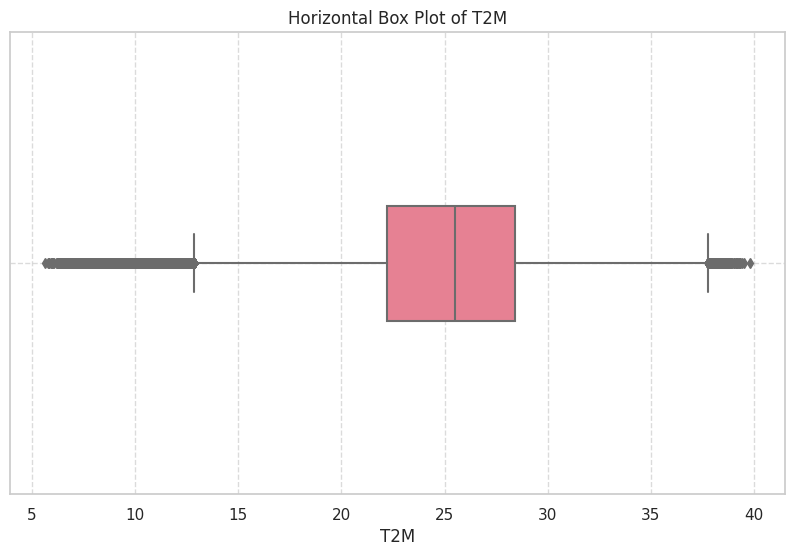

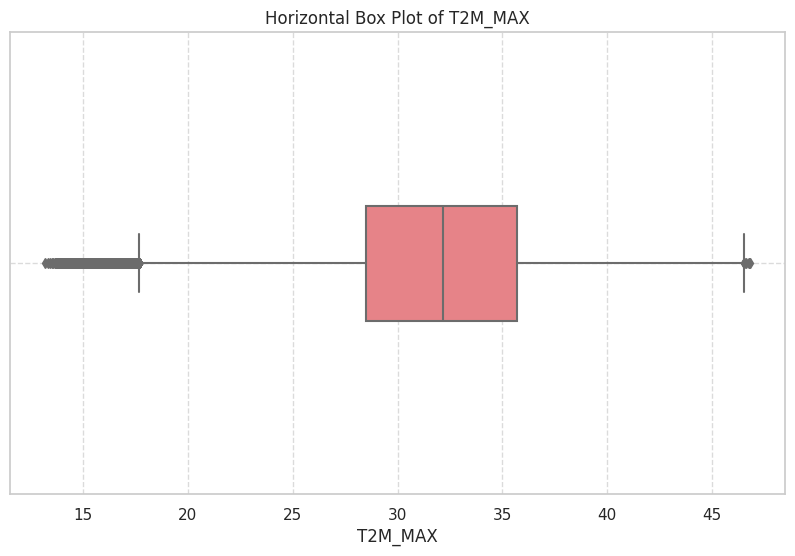

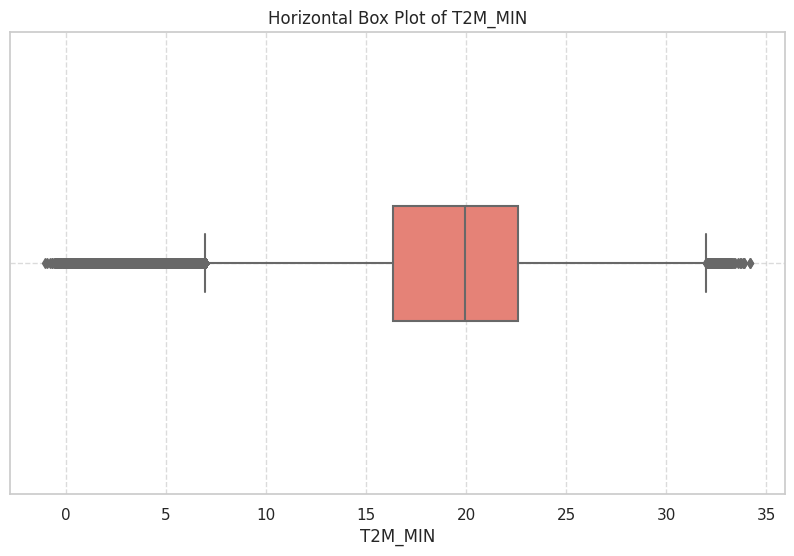

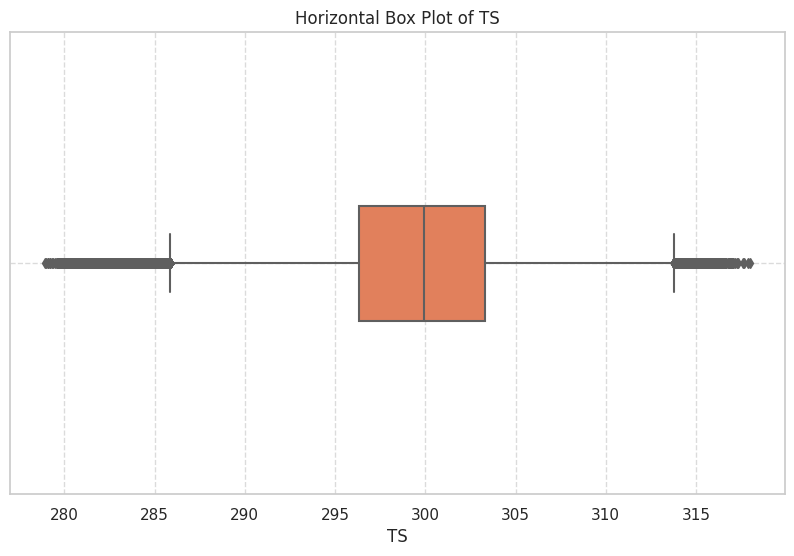

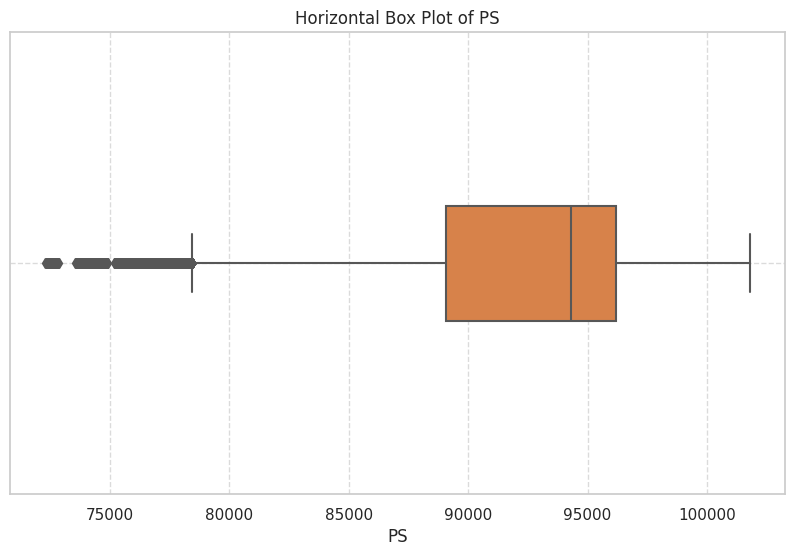

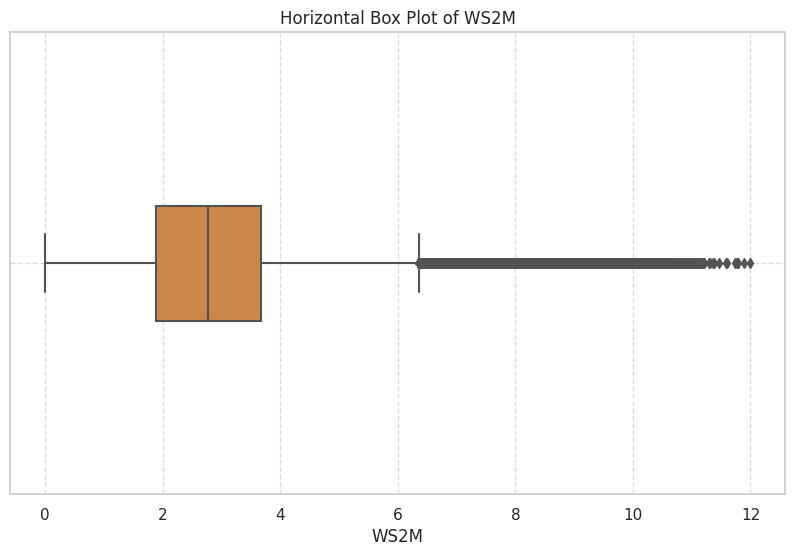

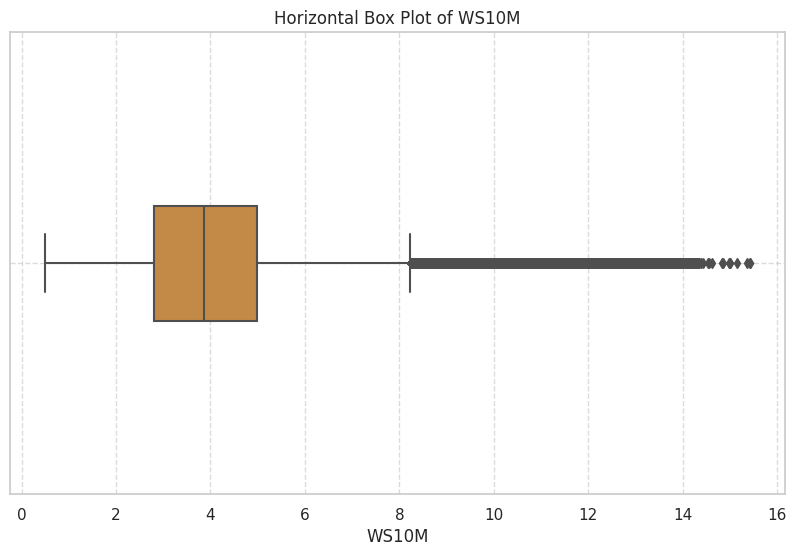

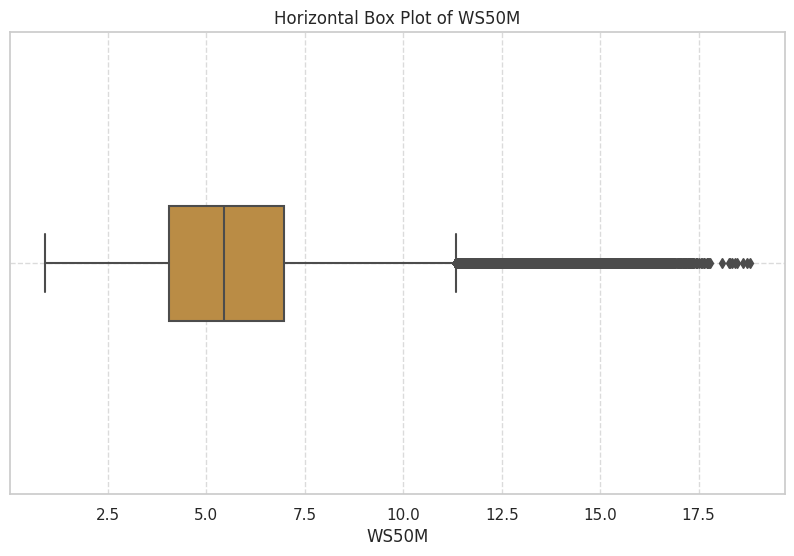

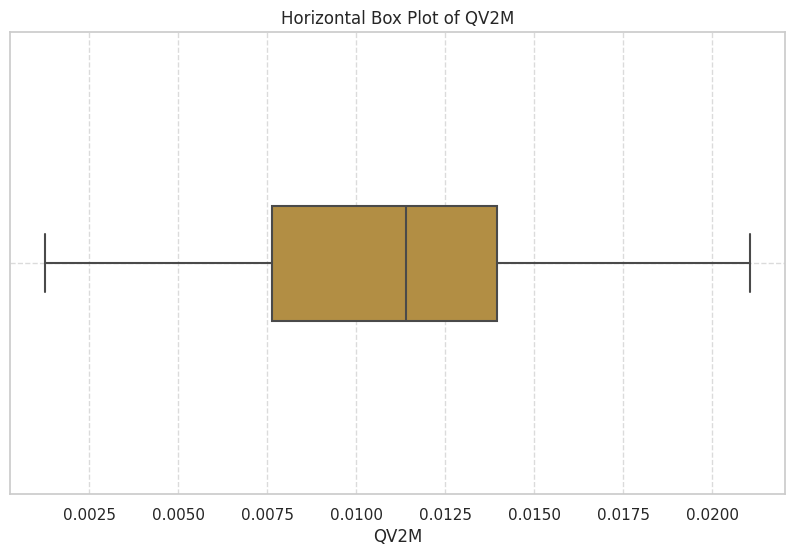

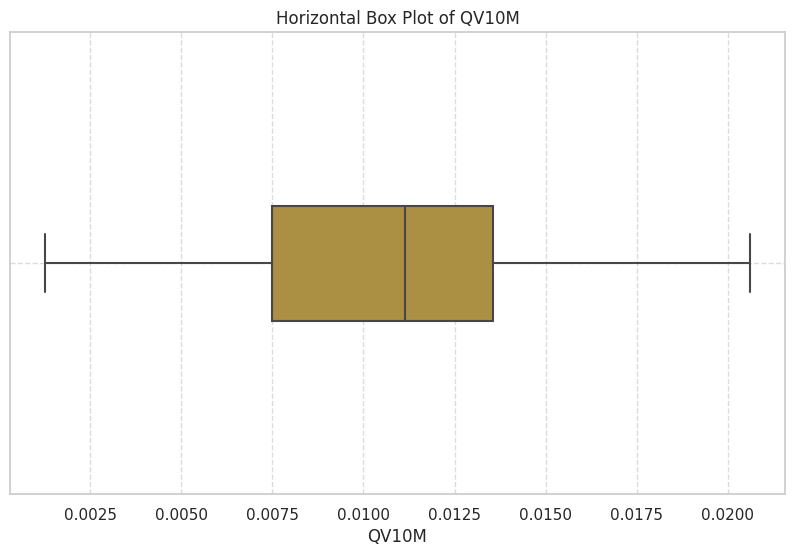

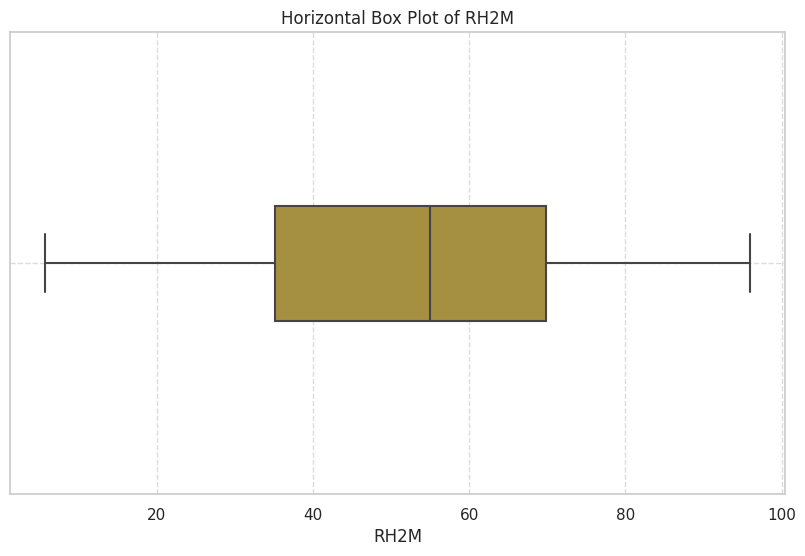

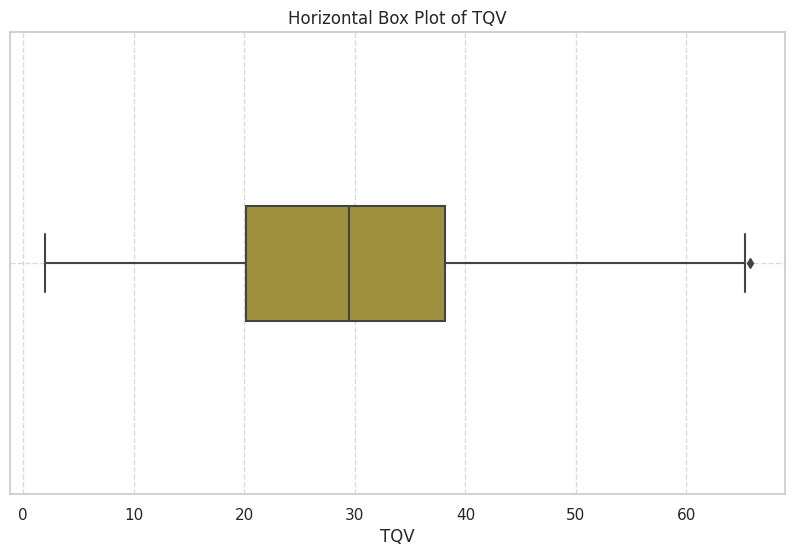

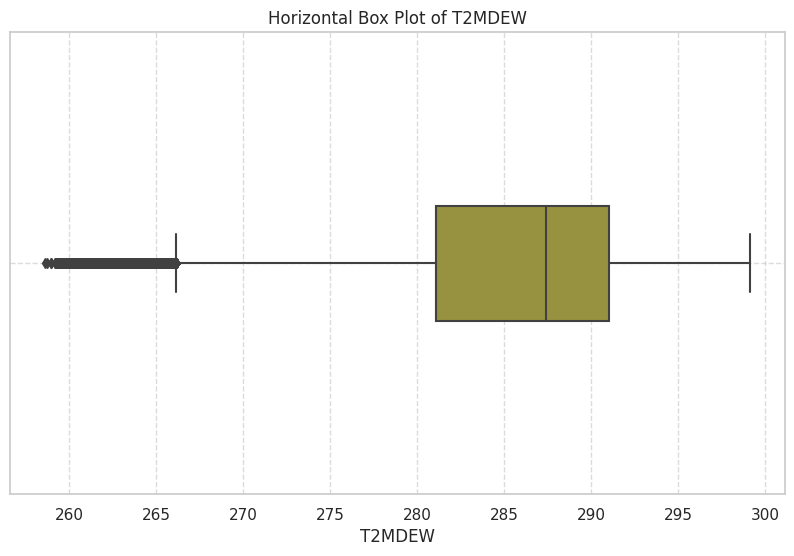

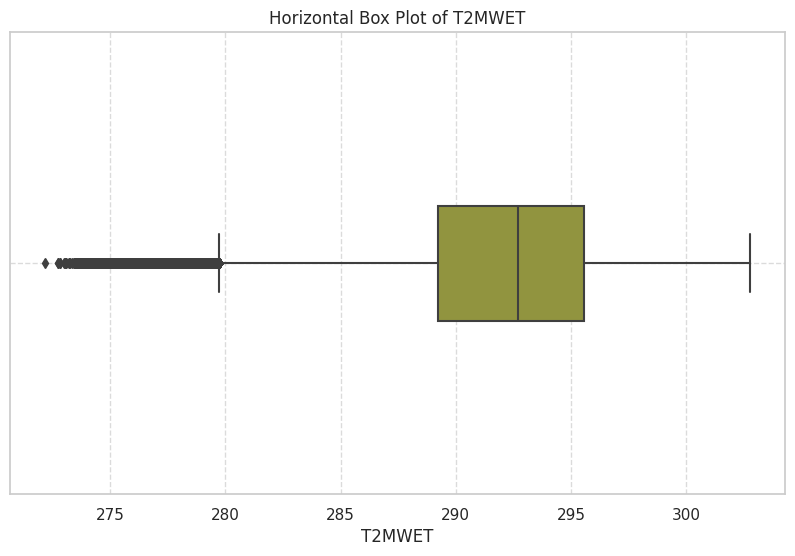

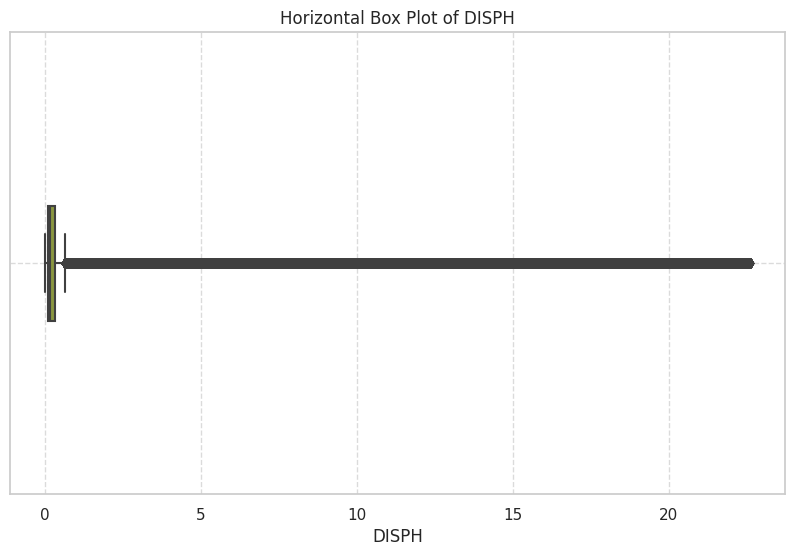

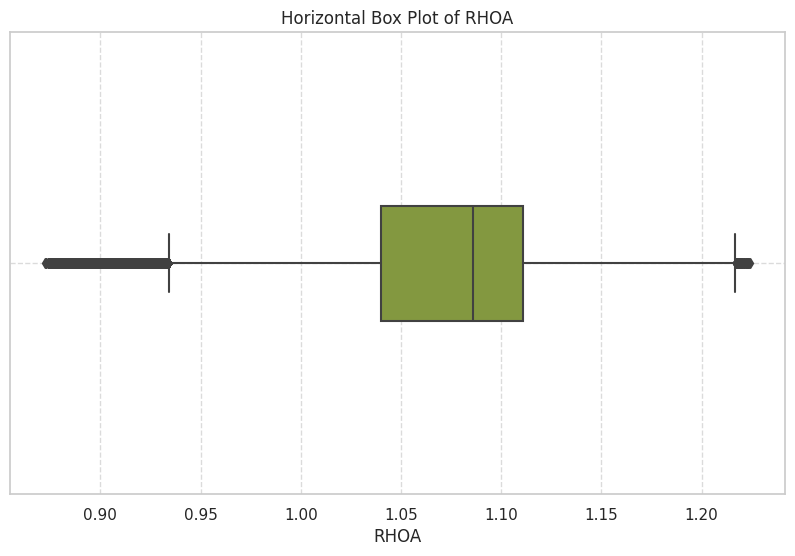

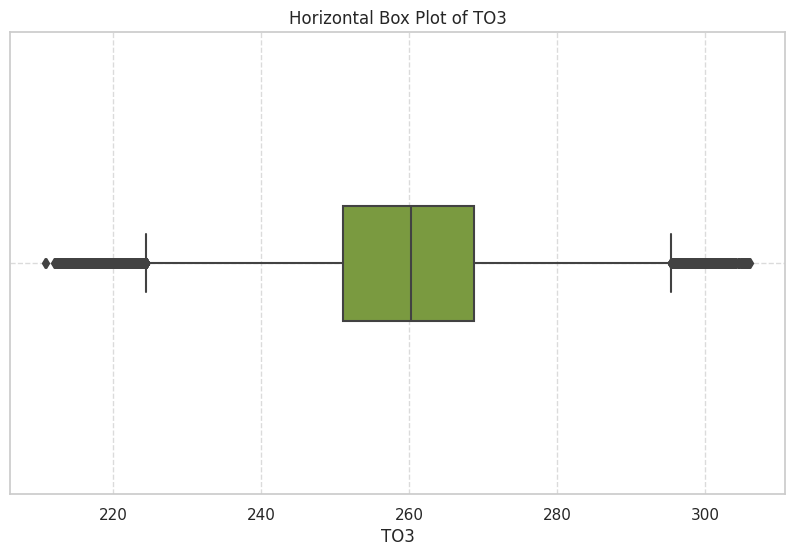

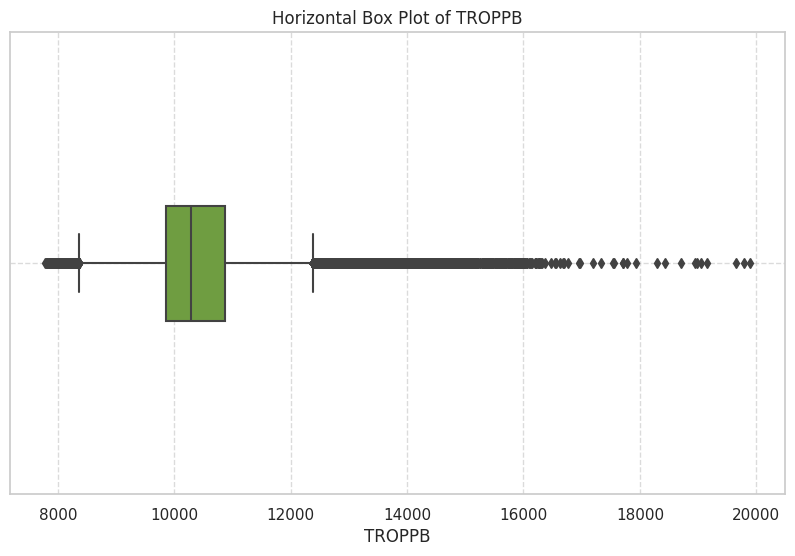

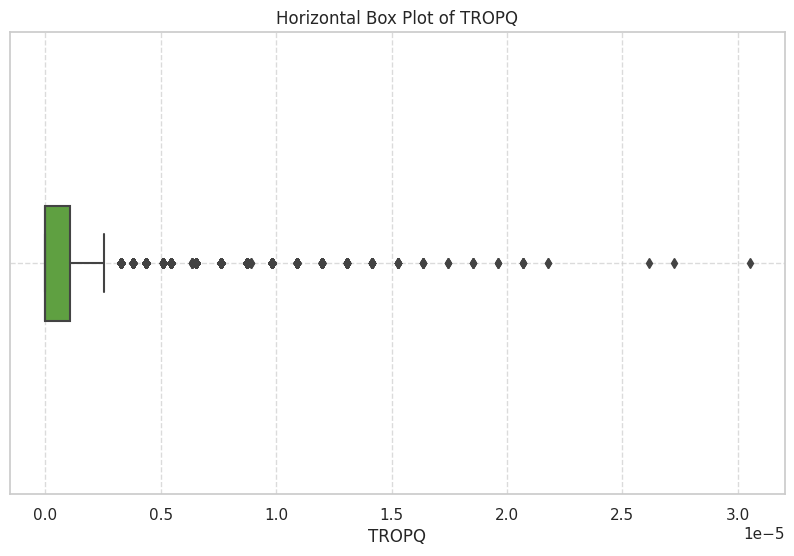

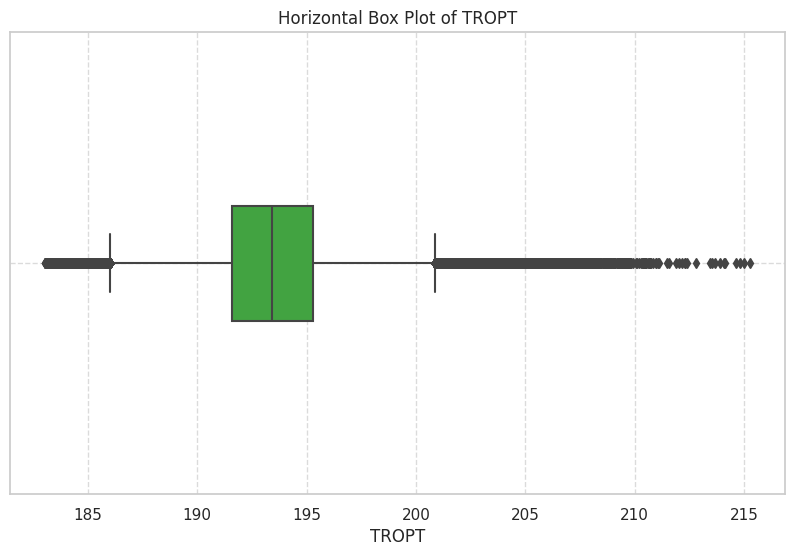

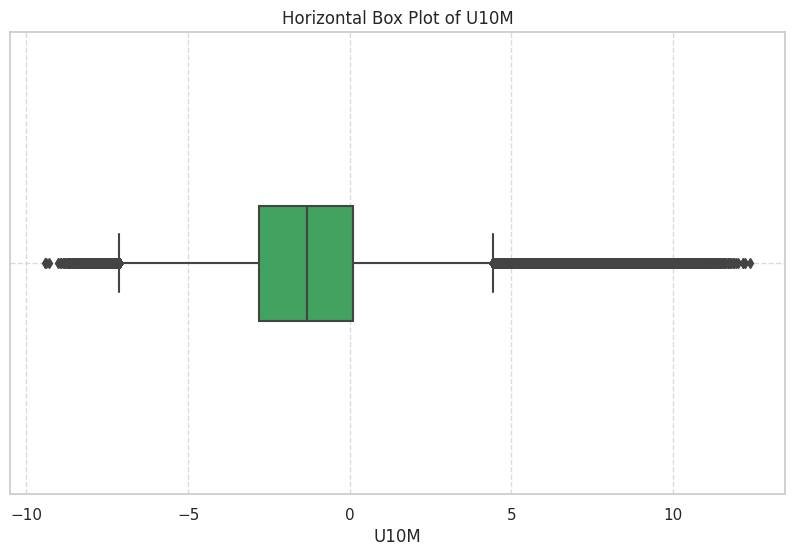

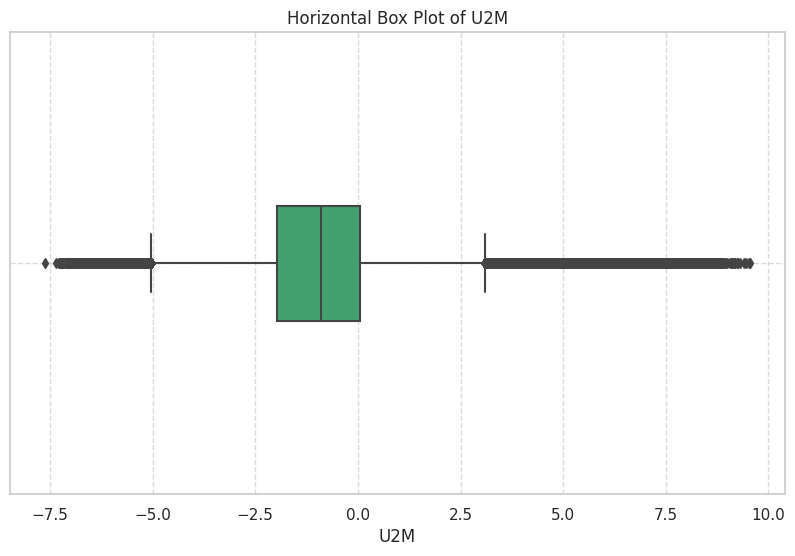

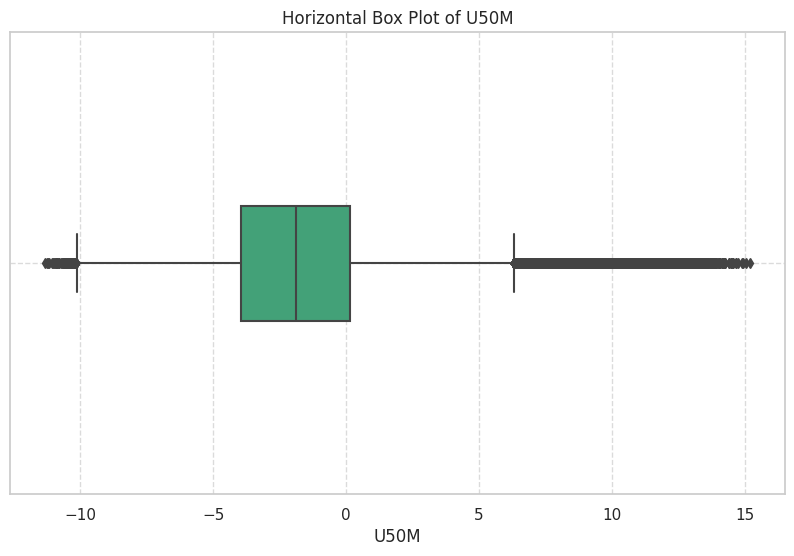

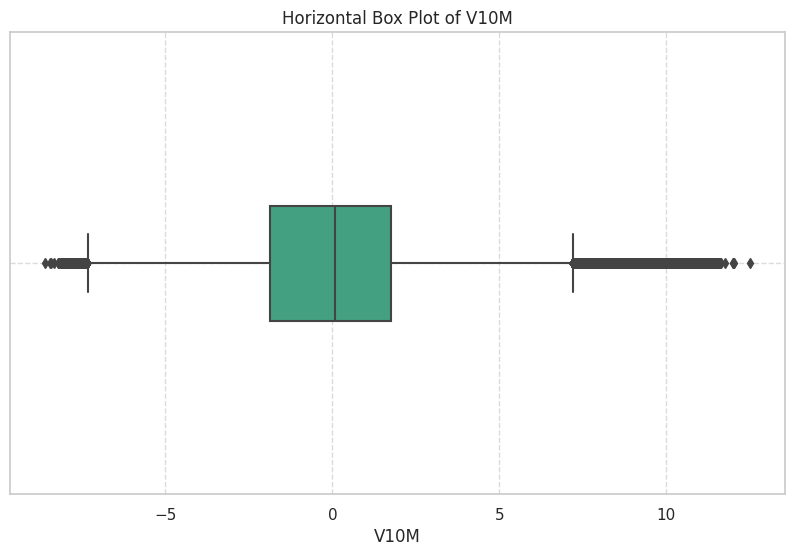

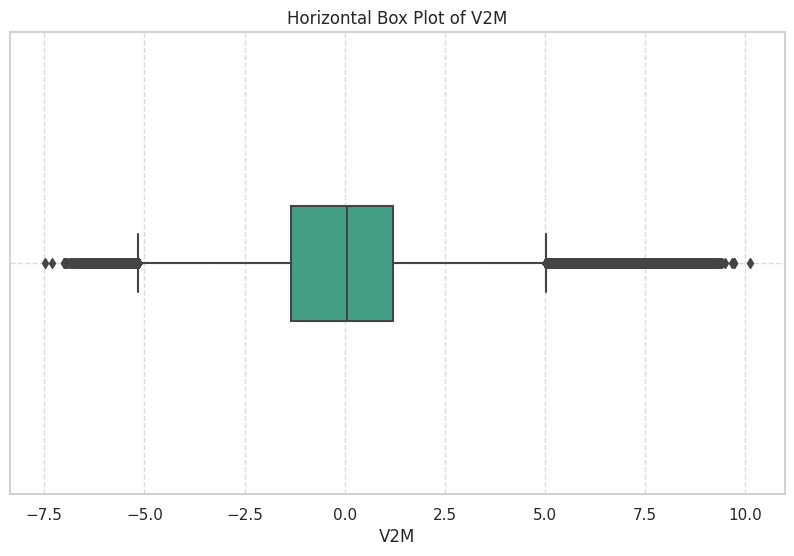

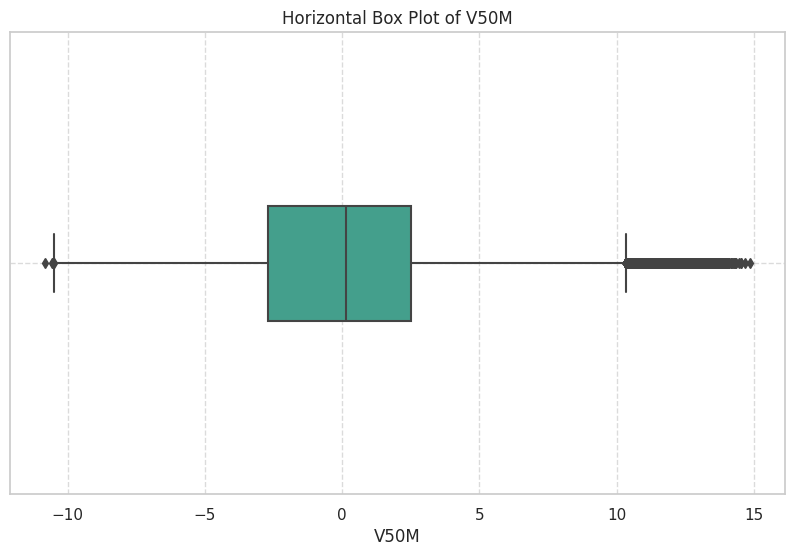

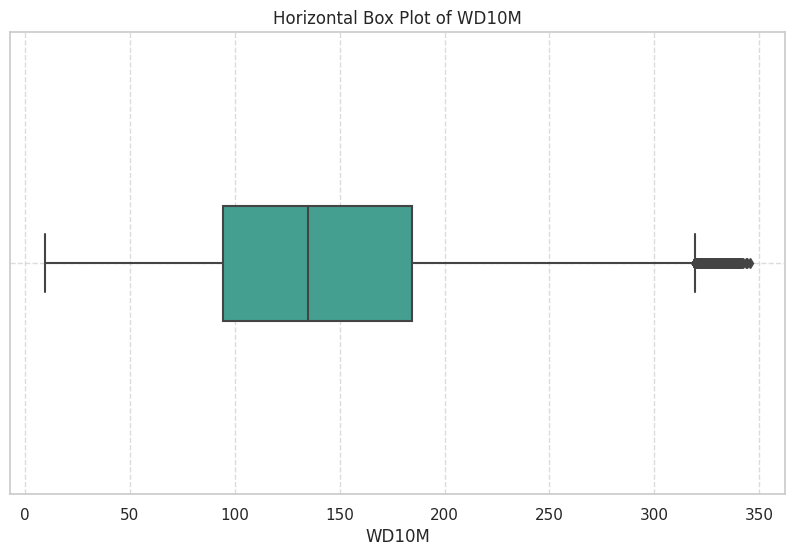

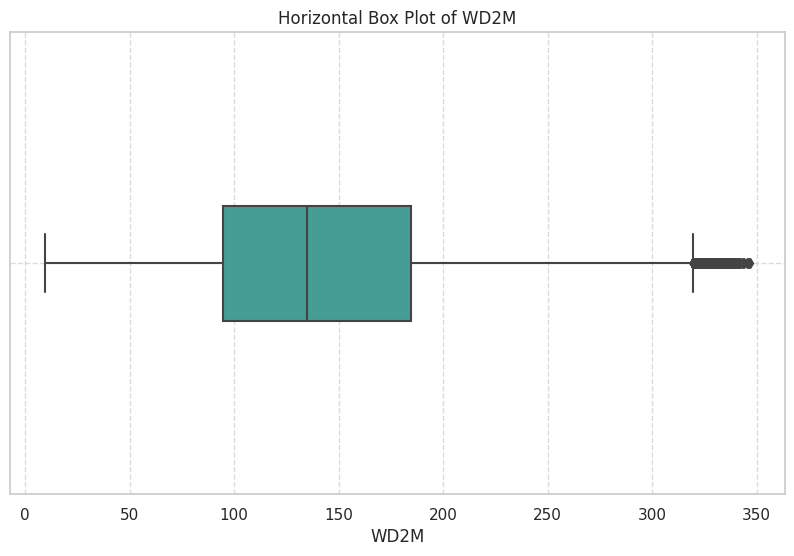

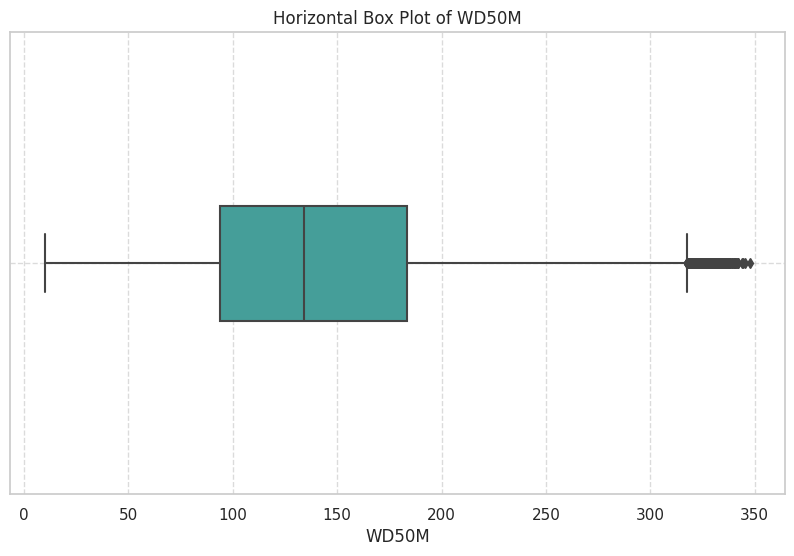

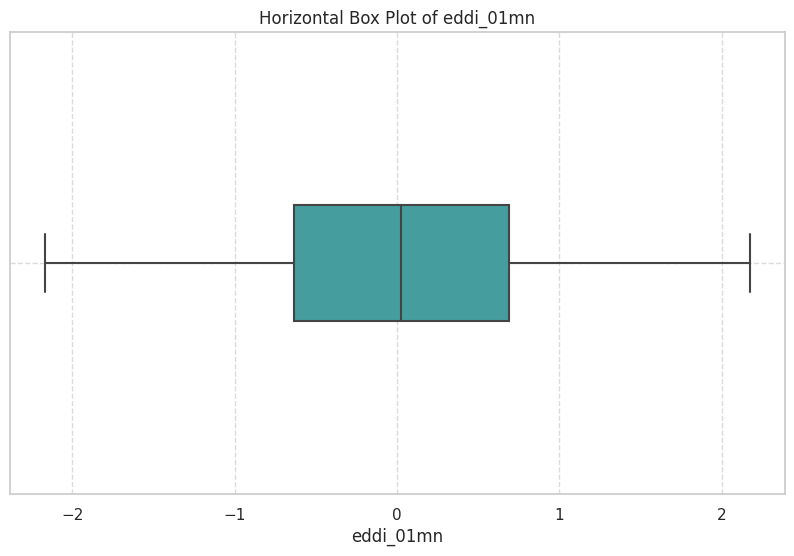

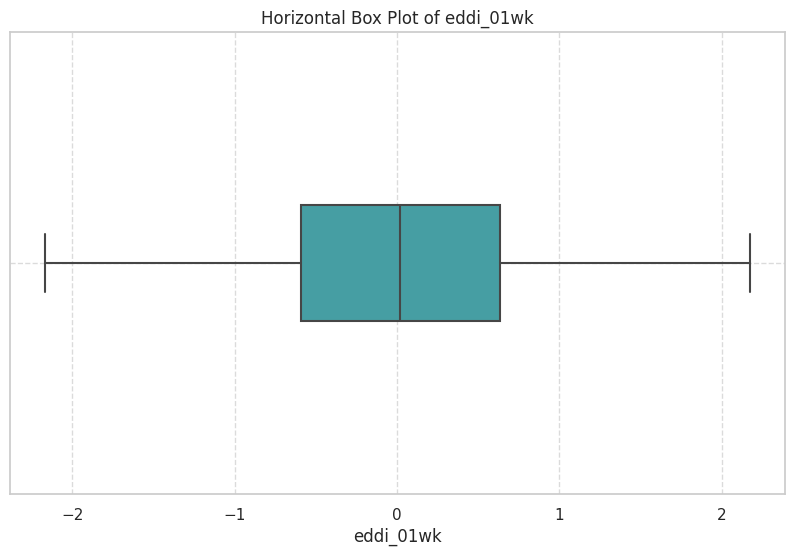

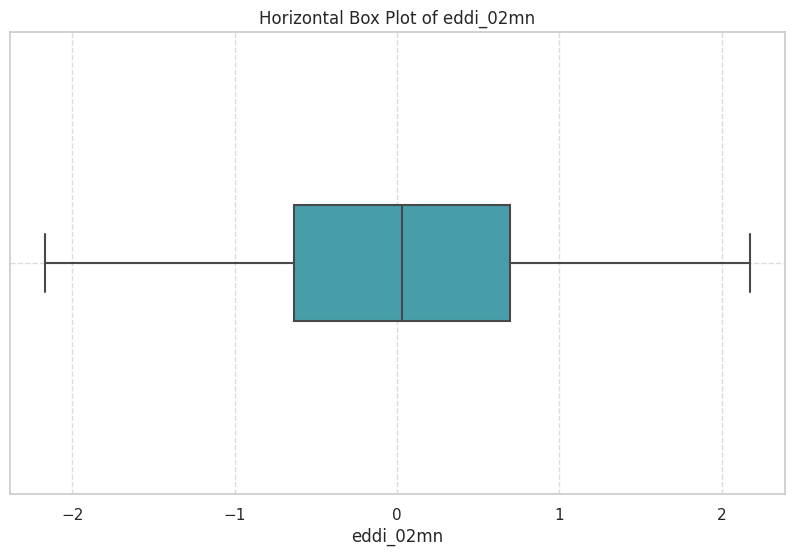

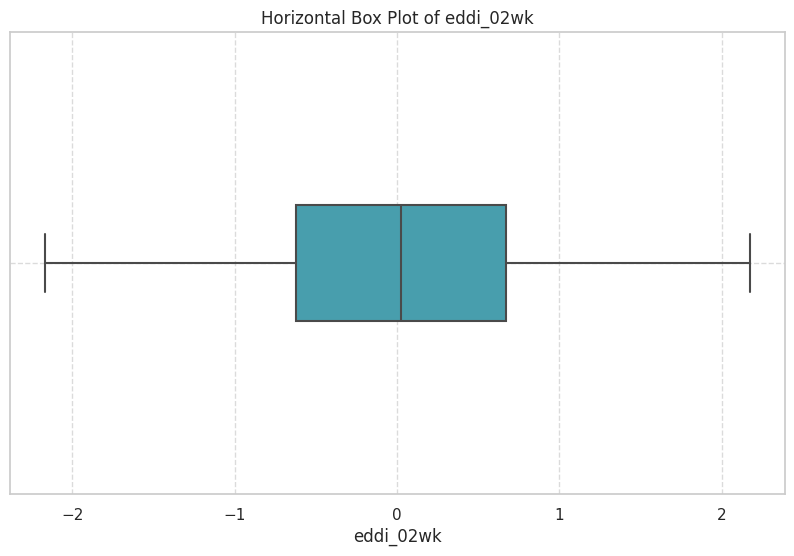

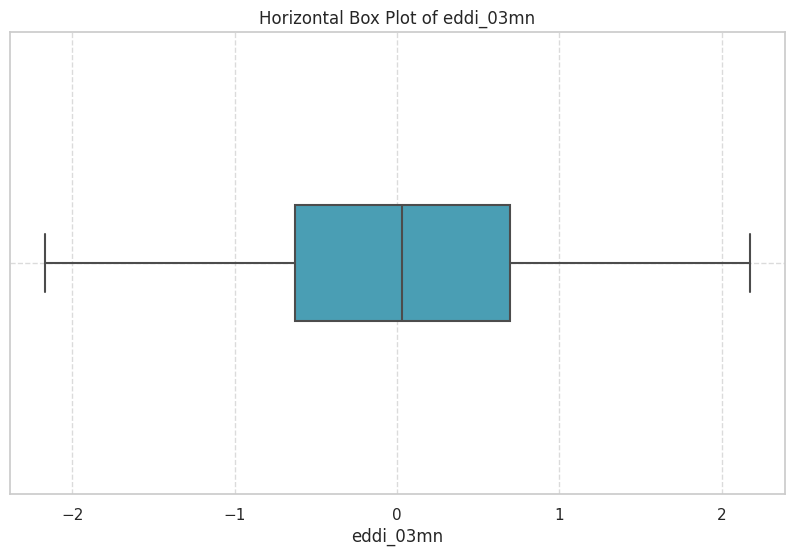

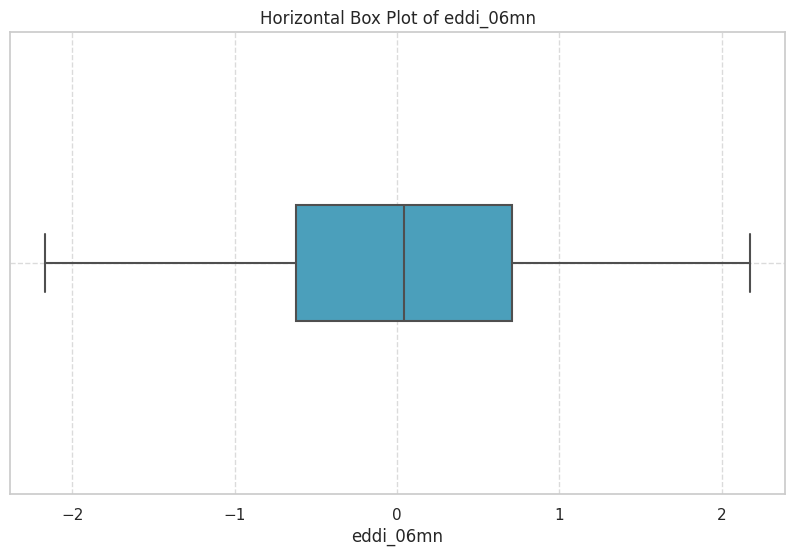

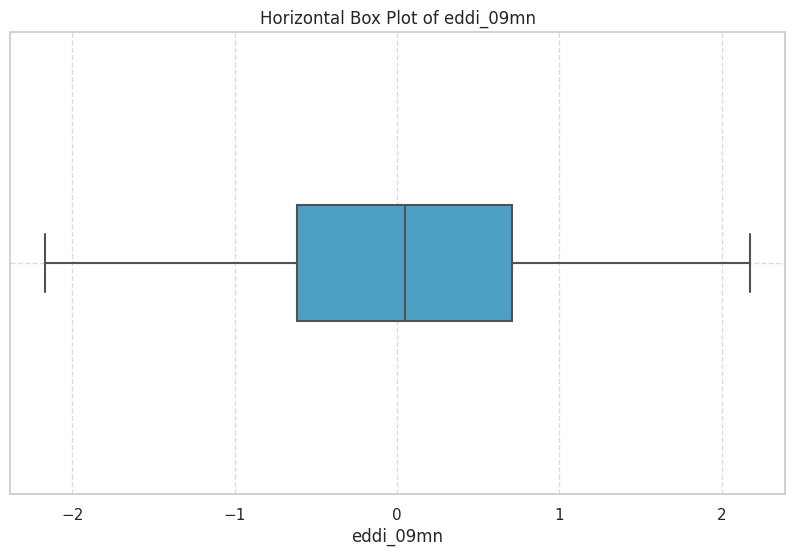

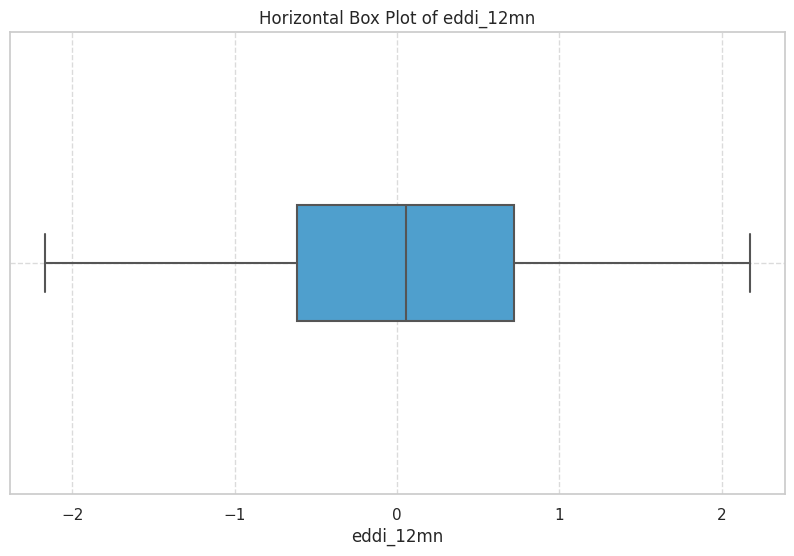

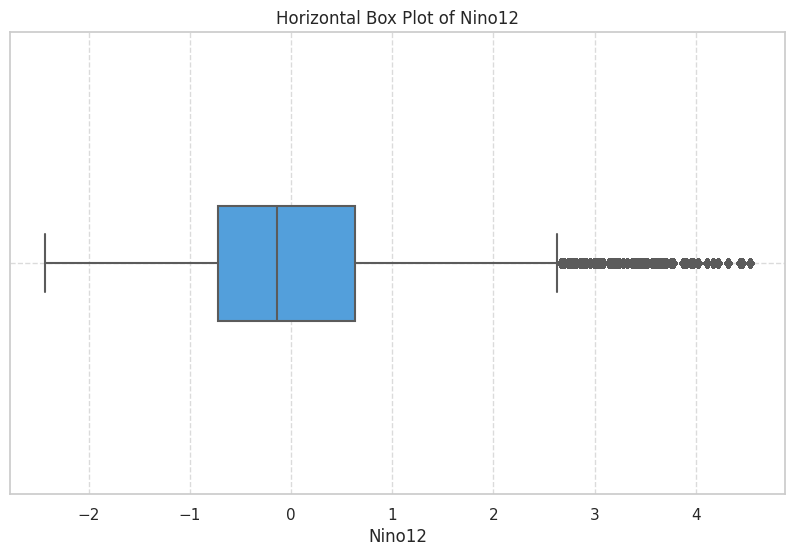

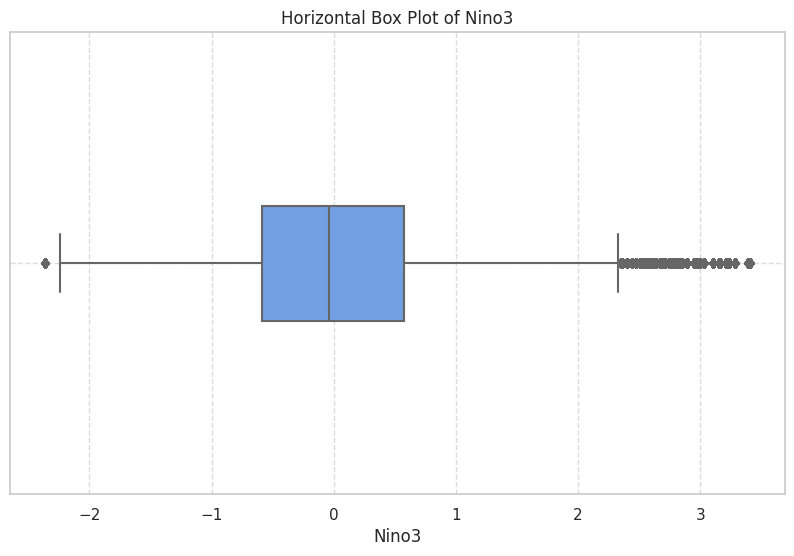

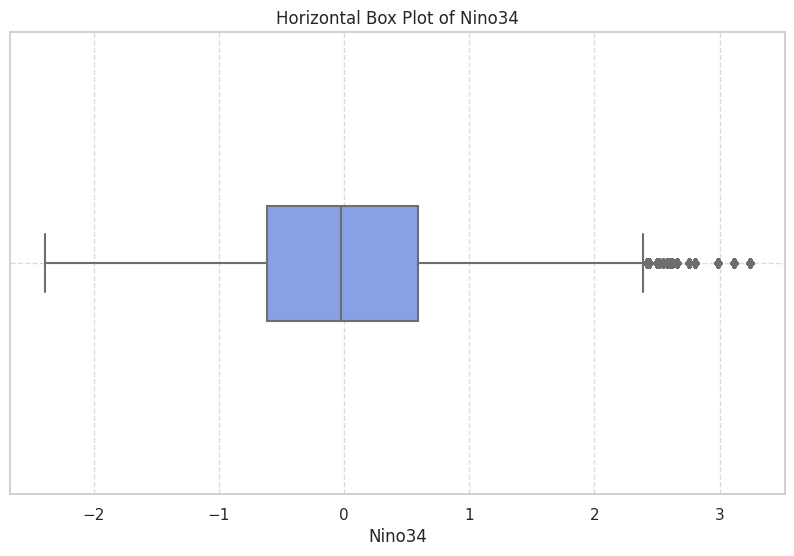

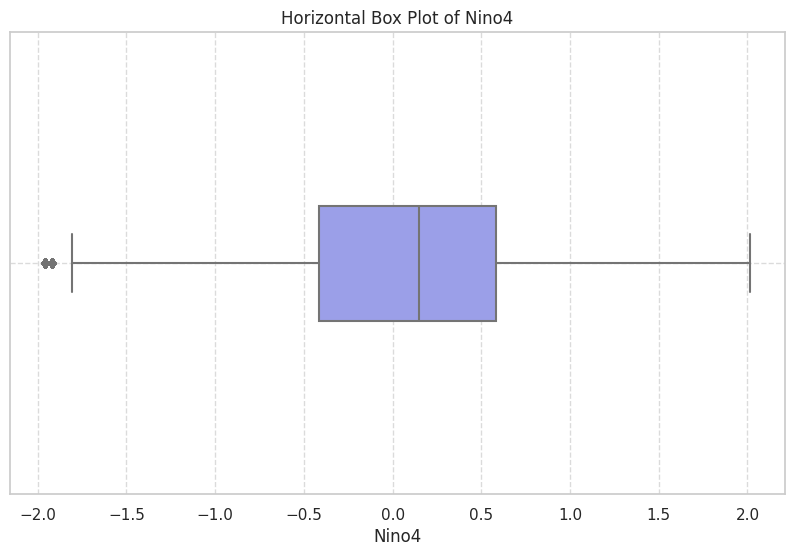

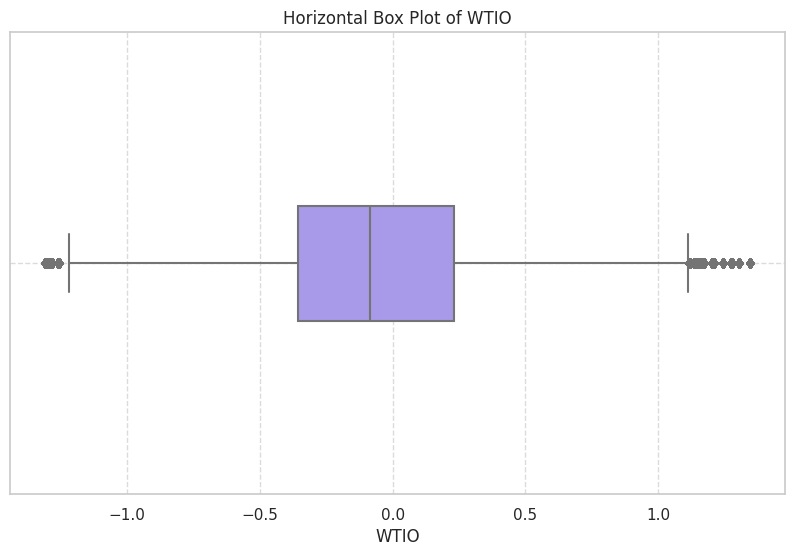

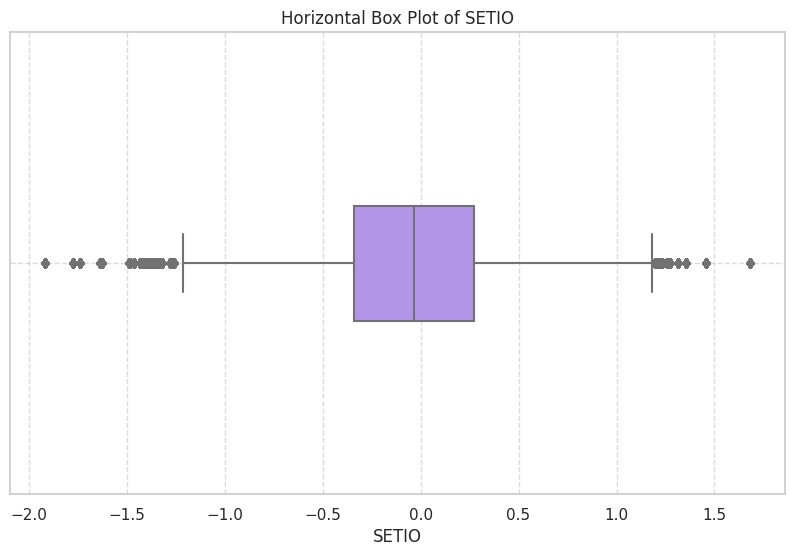

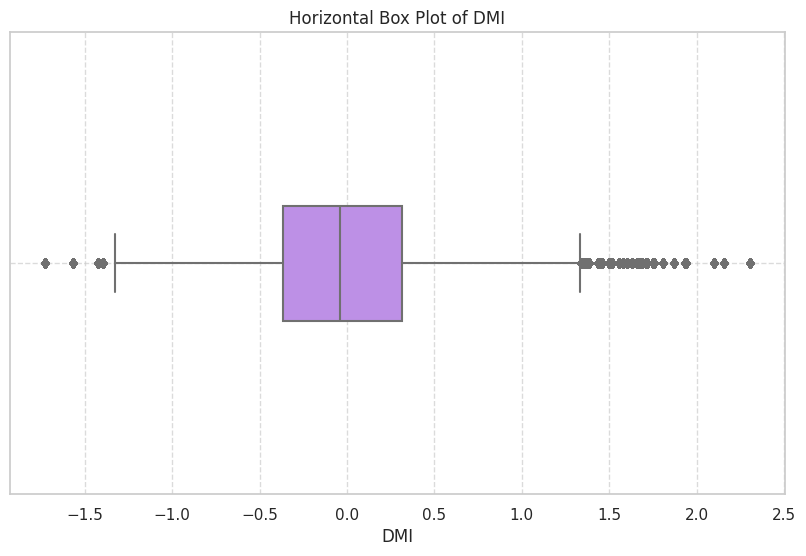

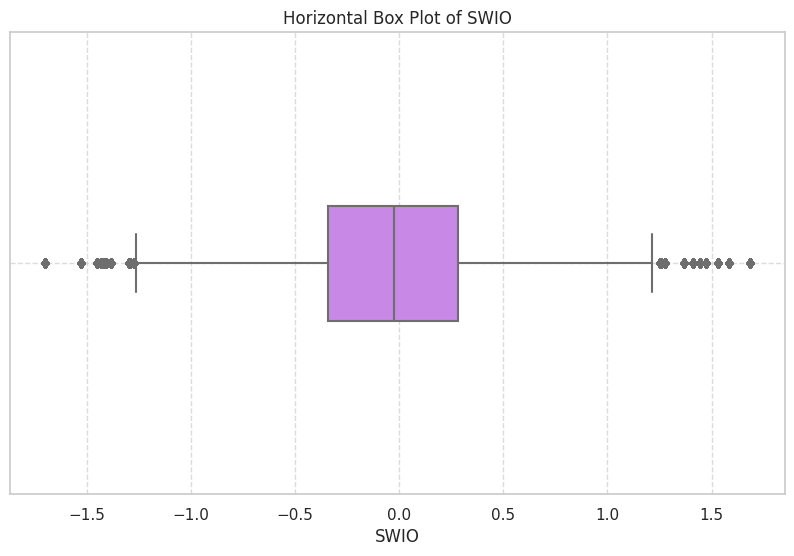

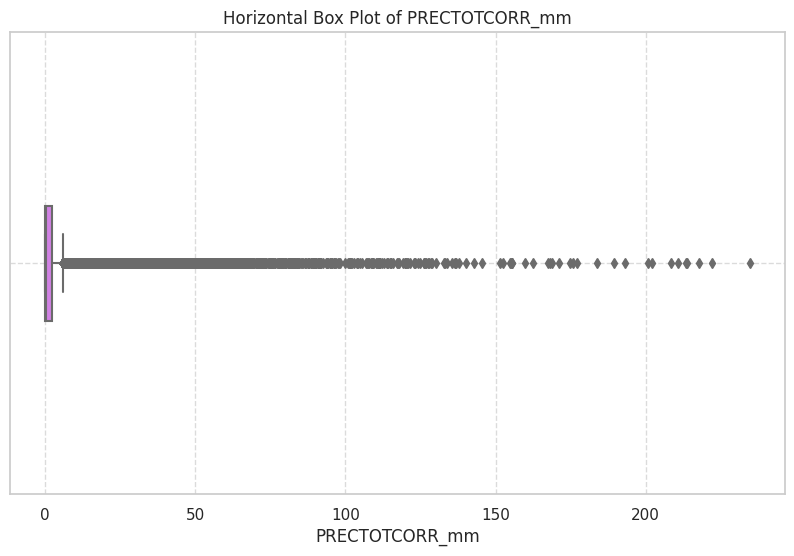

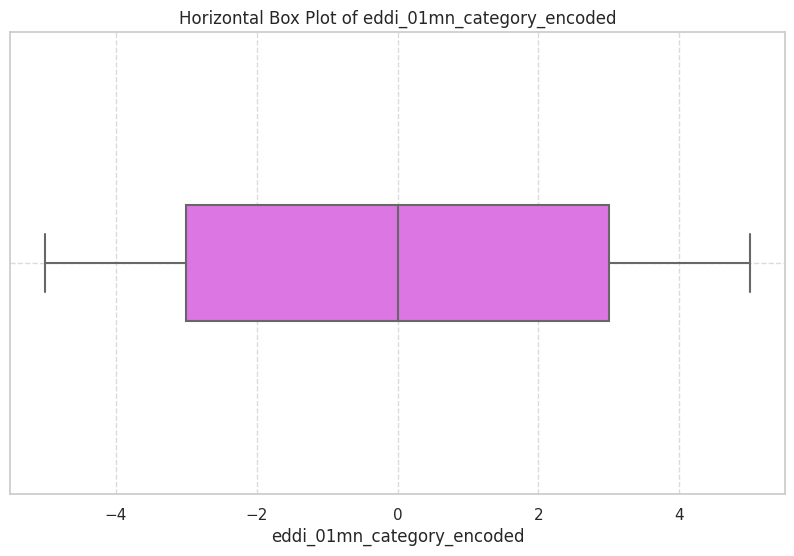

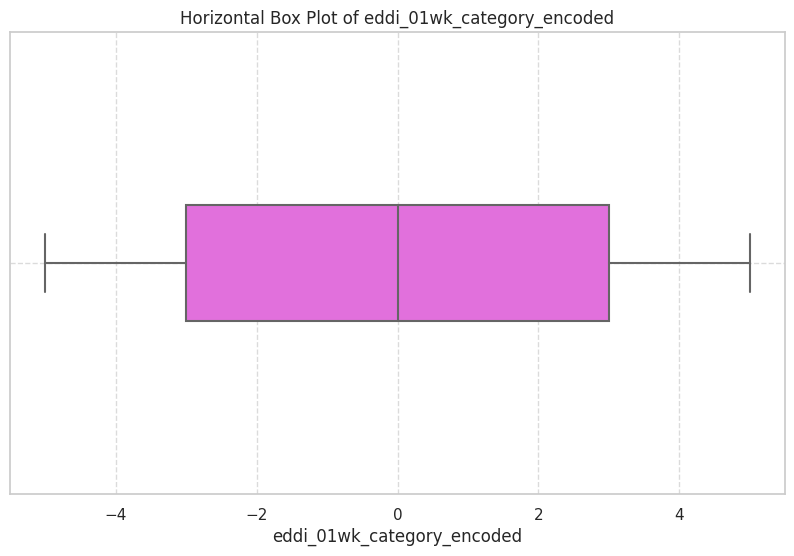

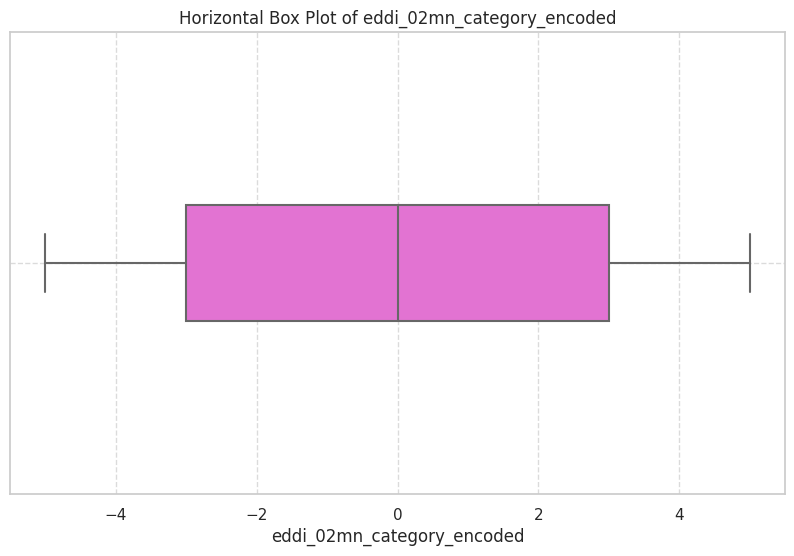

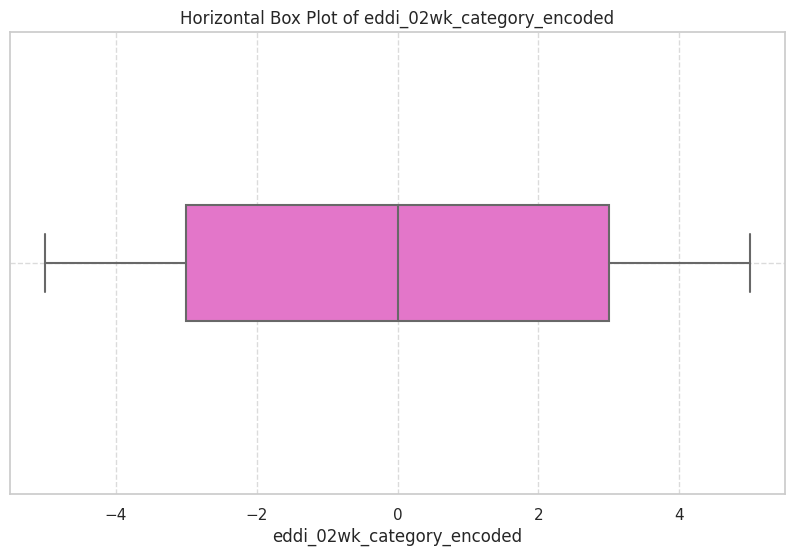

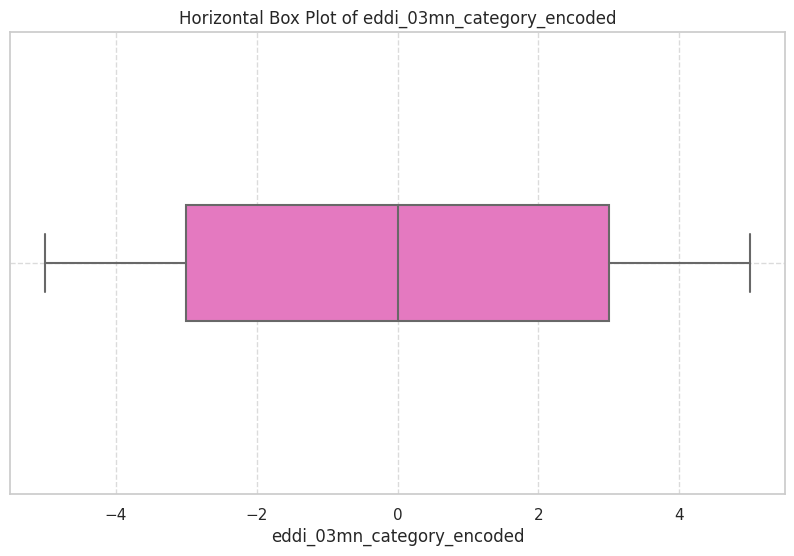

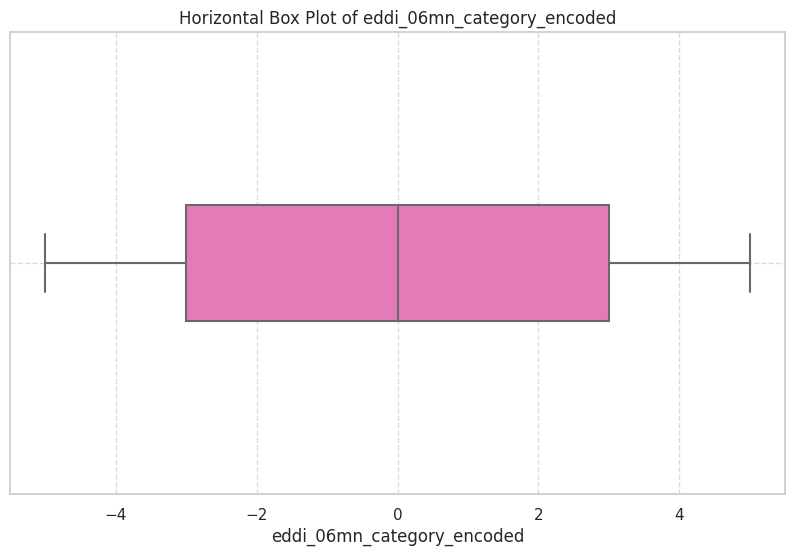

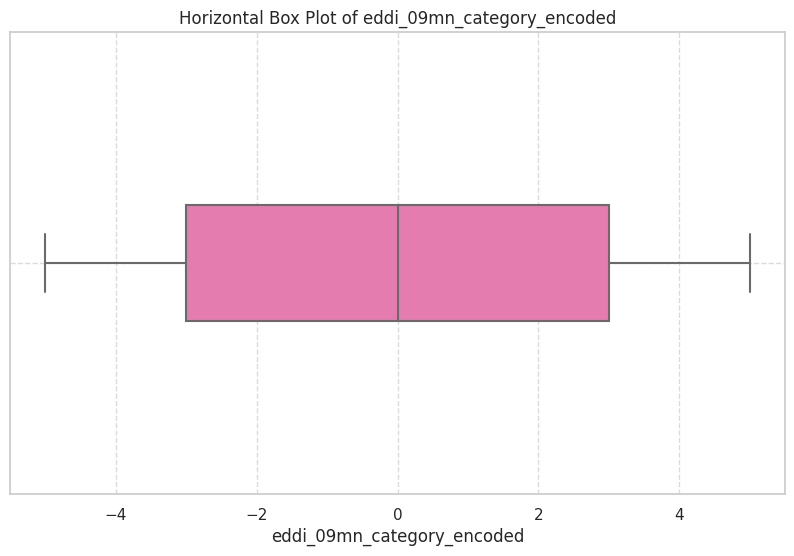

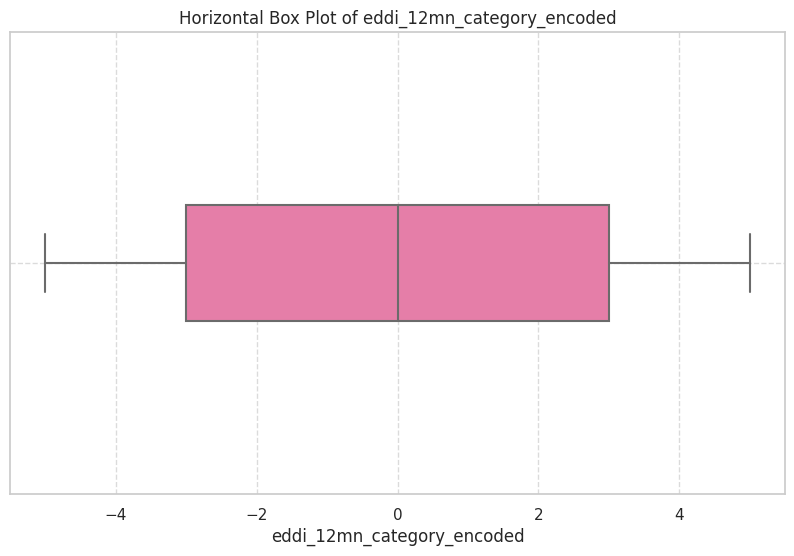

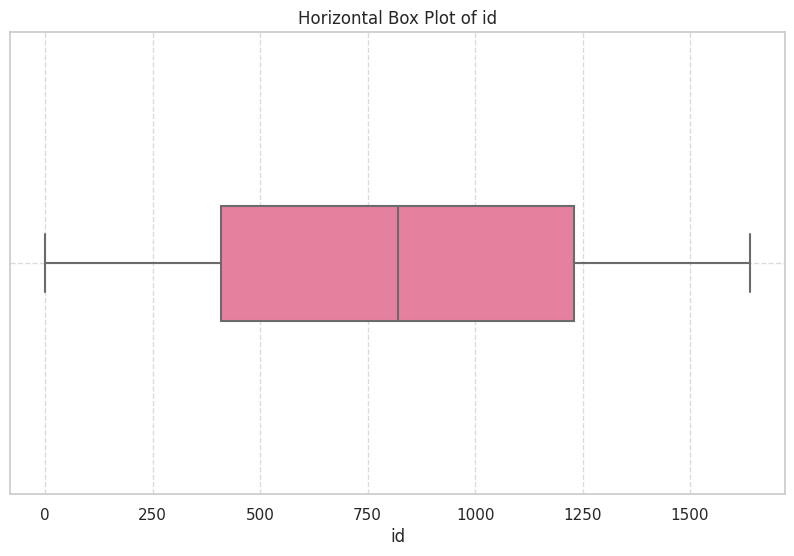

In [23]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

def plot_boxplots(polars_df, box_width=0.5):
    """
    Plot horizontal box plots for each variable in the Polars DataFrame except 'time', 'lat', and 'lon',
    with an adjustable width for the boxes.

    Parameters:
    - polars_df (pl.DataFrame): The input Polars DataFrame containing the data to be plotted.
    - box_width (float): The width of the box in the box plot. Default is 0.5.

    Returns:
    None, displays the box plots.
    """
    # Set the aesthetic appearance of the plots
    sns.set(style="whitegrid")

    # Get the list of columns to plot, excluding 'time', 'lat', and 'lon'
    columns_to_plot = [col for col in polars_df.columns if col not in ['time', 'lat', 'lon']]

    # Define a color palette
    palette = sns.color_palette("husl", len(columns_to_plot))

    # Loop through each column and create a separate boxplot
    for idx, column in enumerate(columns_to_plot):
        # Selecting the column for visualization
        values = polars_df[column].to_numpy()  # Convert to NumPy array for Matplotlib

        # Creating the horizontal box plot for the current column
        plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
        sns.boxplot(x=values, color=palette[idx], width=box_width)  # Use seaborn for a colored boxplot with adjusted width
        plt.xlabel(f'{column}')  # X-axis Label
        plt.title(f'Horizontal Box Plot of {column}')  # Title of the plot
        plt.grid(True, linestyle='--', alpha=0.7)  # Enable grid for better readability
        plt.show()

# Example usage:
plot_boxplots(polars_df, box_width=0.25)


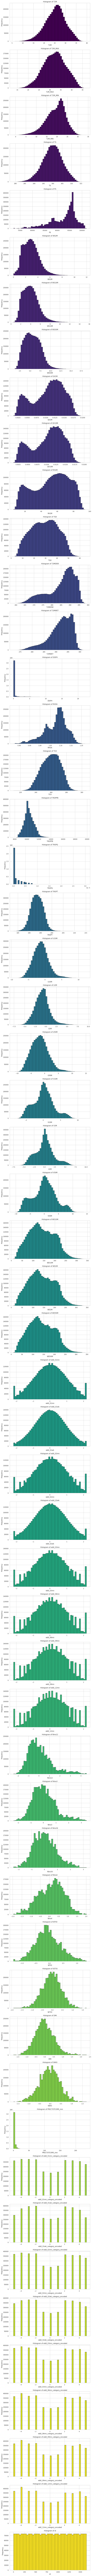

In [24]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def plot_histograms(dataframe: pl.DataFrame, exclude_columns: list = ['time', 'lat', 'lon'], n_bins: int = 50):
    """
    Plot histograms for each column in the DataFrame except the specified columns.

    Parameters:
    - dataframe (pl.DataFrame): The Polars DataFrame containing the data.
    - exclude_columns (list): A list of column names to exclude from histogram plotting.
    - n_bins (int): Number of bins for each histogram.

    This function plots each selected column's histogram in a different color.
    """
    # Selecting the columns that are not in the exclude list
    hist_columns = [col for col in dataframe.columns if col not in exclude_columns]

    # Creating a figure with subplots; adjust the figure size and layout as necessary
    fig, axs = plt.subplots(len(hist_columns), 1, figsize=(10, 5 * len(hist_columns)), tight_layout=True)

    # If there's only one column to plot, axs may not be an array, handle single histogram case
    if len(hist_columns) == 1:
        axs = [axs]

    # Create a colormap
    colors = cm.viridis(np.linspace(0, 1, len(hist_columns)))

    # Plotting histogram for each selected column
    for ax, col, color in zip(axs, hist_columns, colors):
        # Extract the data for the column
        data = dataframe[col].to_numpy()  # Convert to numpy array for compatibility with matplotlib
        
        # Plot the histogram
        ax.hist(data, bins=n_bins, color=color, edgecolor='black')
        
        # Setting the title for each subplot
        ax.set_title(f'Histogram of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')

    # Display the plots
    plt.show()

# Example of usage:
plot_histograms(polars_df) 


# Correlations

## Correlation between all variables 

In [27]:
import plotly.express as px

fig = px.imshow(polars_df, text_auto=True)
fig.show()

KeyboardInterrupt: 